In [20]:
import argparse
import importlib.util

import tensorflow as tf
import h5py
import pickle
import matplotlib.pyplot as plt

from alad_mod.alad import ALAD
from data.hlf_dataset_utils import *
from data.hlf_preprocessing import load
from evaluation.histogram_builder import *
from evaluation.plot_utils import *

In [45]:
data_file = '/home/oliverkn/pro/6021/data_hlf.hdf5'
#data_file = '/home/oliverkn/pro/9865/data_hlf.hdf5'
result_path = '/home/oliverkn/euler/results/record_6021/2_l16'
model_file = 'model-10000000'

target = '../histograms/6021/'

score_type = 'fm'
score_threshold = 88

batch_size = 2 ** 20
max_batches = 100

In [46]:
print('loading data')

if data_file.endswith('.npy'):
    x = np.load(data_file)
elif data_file.endswith('.hdf5'):
    hdf5_file = h5py.File(data_file, "r")
    x = hdf5_file['data']

loading data


In [4]:
print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config_alad, tf.Session())
ad.load(os.path.join(result_path, model_file))

loading alad


W1009 20:49:52.725979 140204151347008 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1009 20:49:52.844354 140204151347008 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1009 20:49:52.850226 140204151347008 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1009 20:49:52.851965 140204151347008 deprecation.py:323] From /home/oliverkn/euler/results/record_6021/2_l16/config.py:81: dens

In [47]:
hist_builder_anomalous = HistogramBuilder(settings_6021)
hist_builder_normal = HistogramBuilder(settings_6021)

n = x.shape[0]

batch_size = batch_size
n_batches = int(n / batch_size) + 1
n_batches = min(max_batches, n_batches)
for t in range(n_batches):
    print('batch number ' + str(t))

    ran_from = t * batch_size
    ran_to = (t + 1) * batch_size
    ran_to = np.clip(ran_to, 0, n)

    x_batch = x[ran_from:ran_to]
    x_batch_transformed = preprocessor.transform(x_batch)

    scores = ad.get_anomaly_scores(x_batch_transformed, type=score_type)
    idx = (scores > score_threshold) * (x_batch[:,3]>0)

    hist_builder_anomalous.add_data(x_batch[idx])
    hist_builder_normal.add_data(x_batch[np.logical_not(idx)])

batch number 0
batch number 1
batch number 2
batch number 3
batch number 4
batch number 5
batch number 6
batch number 7
batch number 8
batch number 9
batch number 10
batch number 11
batch number 12
batch number 13
batch number 14
batch number 15
batch number 16
batch number 17
batch number 18
batch number 19
batch number 20
batch number 21
batch number 22
batch number 23
batch number 24
batch number 25
batch number 26
batch number 27
batch number 28
batch number 29
batch number 30
batch number 31
batch number 32
batch number 33
batch number 34
batch number 35
batch number 36


In [49]:
hist_data_normal = hist_builder_normal.get_histogram_data()
hist_data_anomalous = hist_builder_anomalous.get_histogram_data()

n_normal = hist_data_normal['HT']['n']
n_anomalous = hist_data_anomalous['HT']['n']
frac = n_anomalous / n_normal

print('number of normal events: ' + str(n_normal))
print('number of anomalous events: ' + str(n_anomalous))
print('anomalous fraction: ' + str(n_anomalous / n_normal))
print('%3d_ppm' % (n_anomalous / n_normal*1e6))

number of normal events: 38223489
number of anomalous events: 23949
anomalous fraction: 0.0006265519089583894
626_ppm


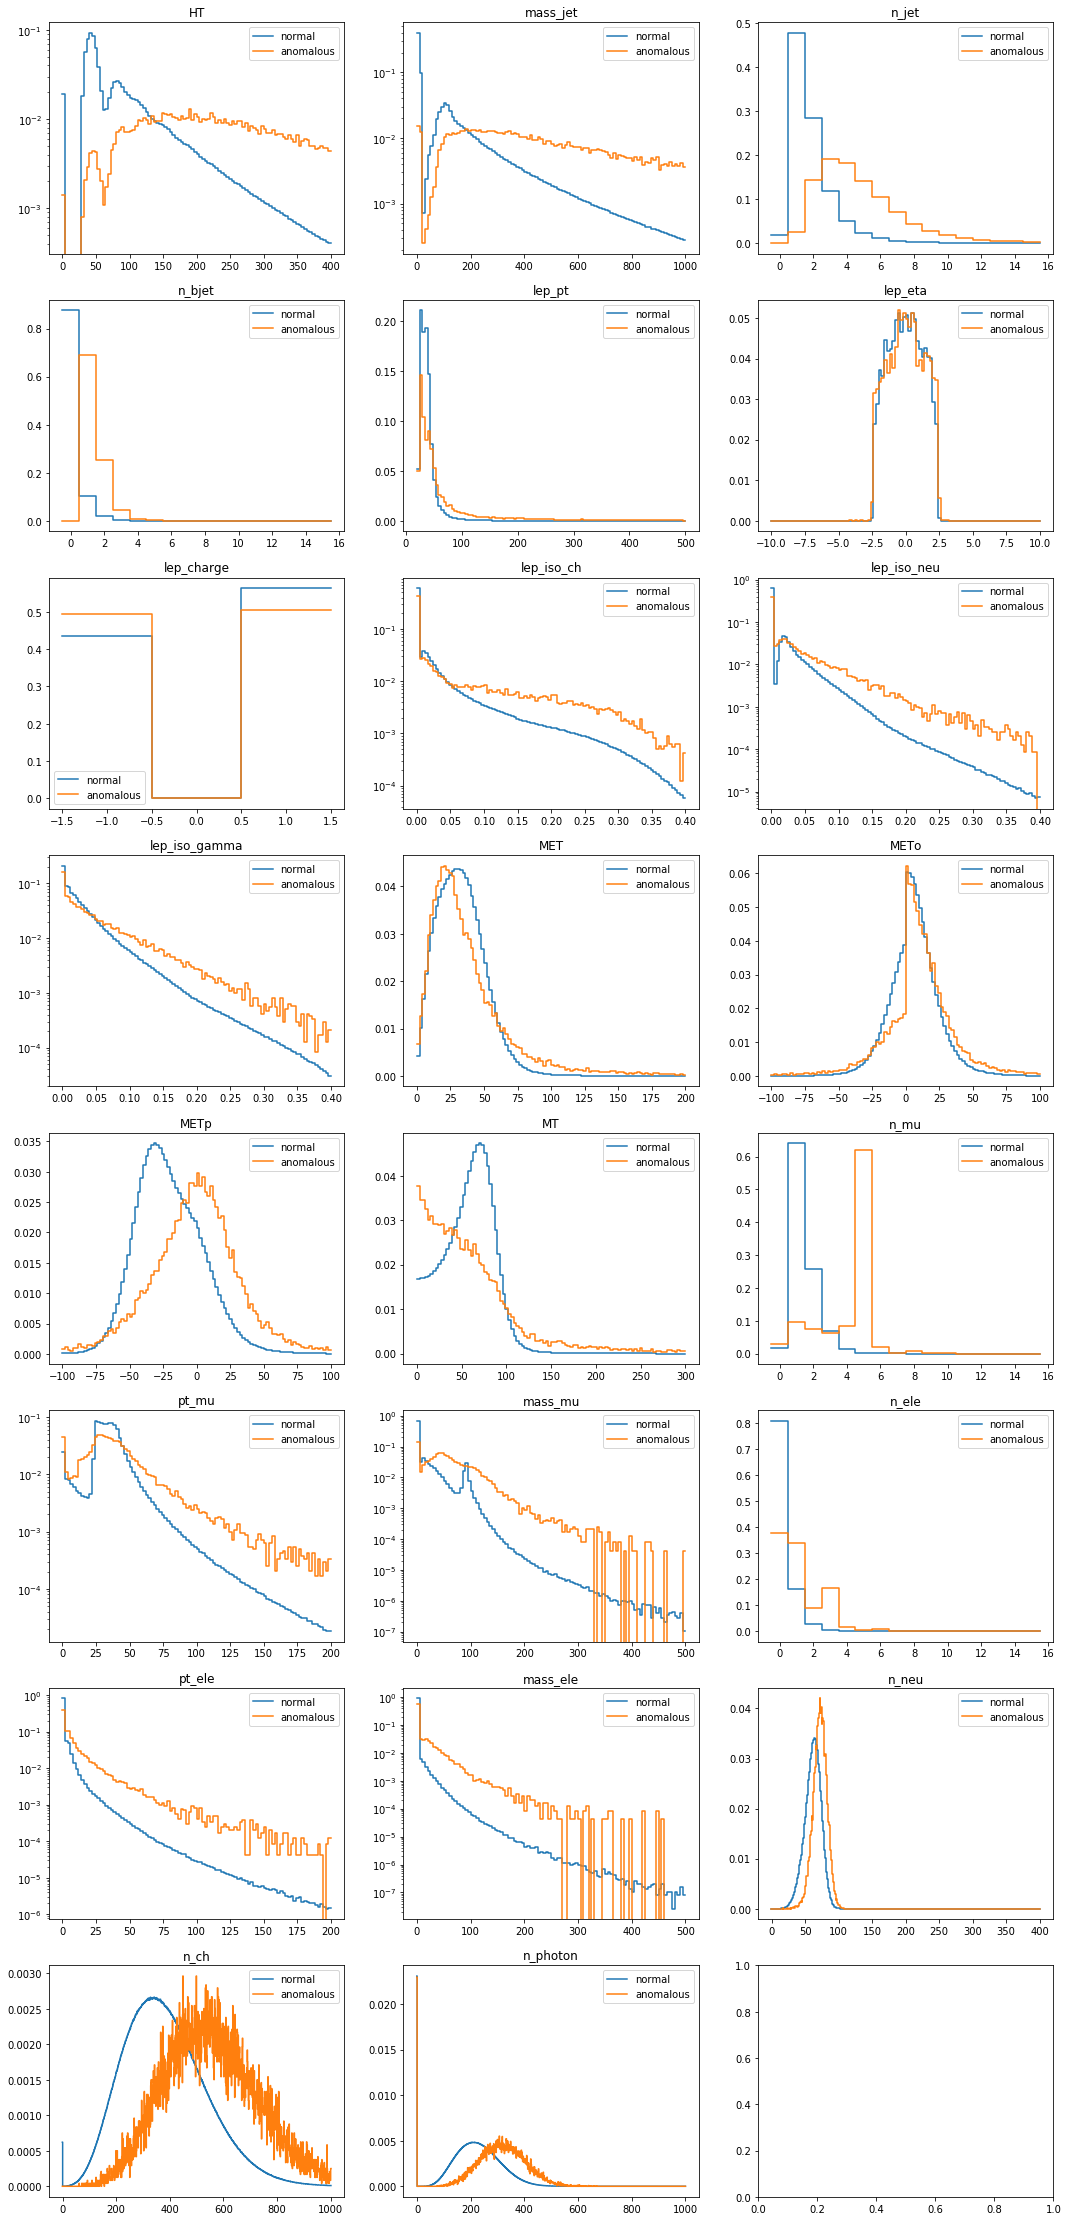

In [50]:
plot_hist([hist_data_normal, hist_data_anomalous], ['normal','anomalous'], settings_6021)

In [51]:
hist_file_normal = os.path.join(target,'%3d_ppm' % (n_anomalous / n_normal*1e6)+'_n.pkl')
hist_file_anomalous = os.path.join(target,'%3d_ppm' % (n_anomalous / n_normal*1e6)+'_a.pkl')

print('saving normal data to ' + hist_file_normal)
pickle.dump(hist_data_normal, open(hist_file_normal, 'wb'))

print('saving anomalous data to ' + hist_file_anomalous)
pickle.dump(hist_data_anomalous, open(hist_file_anomalous, 'wb'))

saving normal data to ../histograms/6021/626_ppm_n.pkl
saving anomalous data to ../histograms/6021/626_ppm_a.pkl
